# Forecasting - Airlines Passengers

### Forecast the Airlines Passengers. 
Prepare a document for each model explaining how many dummy variables you have created and RMSE value for each model. Finally which model you will use for Forecasting.

### Step-1 : Import libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from numpy import log
from numpy import sqrt
from sklearn.model_selection import train_test_split
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
from sklearn.metrics import mean_squared_error
from pandas.plotting import lag_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing  
import statsmodels.graphics.tsaplots as tsa_plots
sb.set_style('darkgrid')
import warnings as warnings
warnings.filterwarnings("ignore")

### Step-2 : Descriptive analysis

### Step-2.1 : Working with Dataset

#### Loading the Dataset

In [3]:
# Importing the dataset
ap_data = pd.read_excel("Airlines+Data.xlsx")

#### Exploring the dataset

In [4]:
# Displaying first ten records
ap_data.head(10)

,Month,Passengers
0,1995-01-01,112
1,1995-02-01,118
2,1995-03-01,132
3,1995-04-01,129
4,1995-05-01,121
5,1995-06-01,135
6,1995-07-01,148
7,1995-08-01,148
8,1995-09-01,136
9,1995-10-01,119


In [5]:
# Shape of the data
ap_data.shape

(96, 2)

In [6]:
# Summary of the data
ap_data.describe()

,Passengers
count,96.000000
mean,213.708333
std,71.918216
min,104.000000
25%,156.000000
50%,200.000000
75%,264.750000
max,413.000000


In [7]:
# Check the data types
ap_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month       96 non-null     datetime64[ns]
 1   Passengers  96 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.6 KB


#### Modifying the dataset

In [8]:
ap_data.rename(columns = {"Month": "date","Passengers":"passengers"}, inplace = True)

### Step-2.2 : Handling missing values

In [9]:
# Check for Null values
ap_data.isnull().sum()

date          0
passengers    0
dtype: int64

In [10]:
# Check for duplicate values
ap_data[ap_data.duplicated()].shape

(0, 2)

In [11]:
ap_data[ap_data.duplicated()]

,date,passengers


<AxesSubplot:>

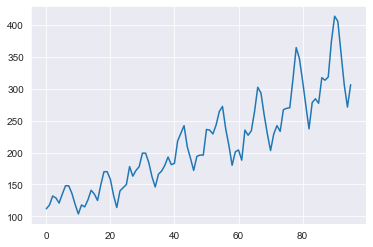

In [12]:
ap_data.passengers.plot()

### Step-3 : Feature Engineering

In [13]:
ap_data_mdf = ap_data.copy()
ap_data_mdf.head()

,date,passengers
0,1995-01-01,112
1,1995-02-01,118
2,1995-03-01,132
3,1995-04-01,129
4,1995-05-01,121


In [14]:
t_list = [x for x in range(1,len(ap_data)+1)]
ap_data_mdf['t'] = t_list

ap_data_mdf['t_square'] = ap_data_mdf['t']*ap_data_mdf['t']

#log transformation
ap_data_mdf['log_passengers'] = log(ap_data.passengers)
ap_data_mdf.head()

,date,passengers,t,t_square,log_passengers
0,1995-01-01,112,1,1,4.718499
1,1995-02-01,118,2,4,4.770685
2,1995-03-01,132,3,9,4.882802
3,1995-04-01,129,4,16,4.859812
4,1995-05-01,121,5,25,4.795791


In [15]:
ap_data_mdf['months'] = ap_data['date'].dt.month_name() # saves months name from date
ap_data_mdf['months'] = [x[0:3] for x in ap_data_mdf.months] # will take only first 3 chars of months like jan,feb
ap_data_mdf['year']   = ap_data['date'].dt.year
ap_data_mdf

,date,passengers,t,t_square,log_passengers,months,year
0,1995-01-01,112,1,1,4.718499,Jan,1995
1,1995-02-01,118,2,4,4.770685,Feb,1995
2,1995-03-01,132,3,9,4.882802,Mar,1995
3,1995-04-01,129,4,16,4.859812,Apr,1995
4,1995-05-01,121,5,25,4.795791,May,1995
...,...,...,...,...,...,...,...
91,2002-08-01,405,92,8464,6.003887,Aug,2002
92,2002-09-01,355,93,8649,5.872118,Sep,2002
93,2002-10-01,306,94,8836,5.723585,Oct,2002
94,2002-11-01,271,95,9025,5.602119,Nov,2002


In [16]:
dummy = pd.DataFrame(pd.get_dummies(ap_data_mdf['months']))
dummy.reindex(sorted(dummy.columns), axis=1)
colsequence = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
dummy = dummy.reindex(columns=colsequence ) #sorts the column headings

ap_data_mdf = pd.concat([ap_data_mdf,dummy], axis=1)
ap_data_mdf

,date,passengers,t,t_square,log_passengers,months,year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,1995-01-01,112,1,1,4.718499,Jan,1995,1,0,0,0,0,0,0,0,0,0,0,0
1,1995-02-01,118,2,4,4.770685,Feb,1995,0,1,0,0,0,0,0,0,0,0,0,0
2,1995-03-01,132,3,9,4.882802,Mar,1995,0,0,1,0,0,0,0,0,0,0,0,0
3,1995-04-01,129,4,16,4.859812,Apr,1995,0,0,0,1,0,0,0,0,0,0,0,0
4,1995-05-01,121,5,25,4.795791,May,1995,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,2002-08-01,405,92,8464,6.003887,Aug,2002,0,0,0,0,0,0,0,1,0,0,0,0
92,2002-09-01,355,93,8649,5.872118,Sep,2002,0,0,0,0,0,0,0,0,1,0,0,0
93,2002-10-01,306,94,8836,5.723585,Oct,2002,0,0,0,0,0,0,0,0,0,1,0,0
94,2002-11-01,271,95,9025,5.602119,Nov,2002,0,0,0,0,0,0,0,0,0,0,1,0


### Step-4 : Data Visualisation

#### Heat map

<AxesSubplot:xlabel='months', ylabel='year'>

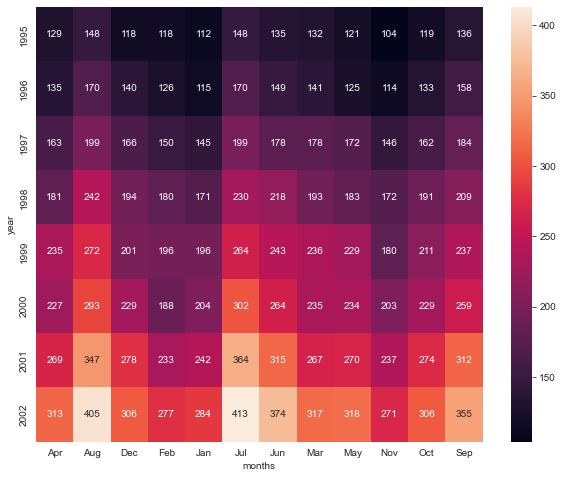

In [17]:
heatmap_passengers = pd.pivot_table(data=ap_data_mdf,values='passengers',index='year',
                                    columns='months',aggfunc='mean',fill_value=0)
plt.figure(figsize=(10,8))
sb.heatmap(data =heatmap_passengers , annot=True,fmt='g')

#### Line plot

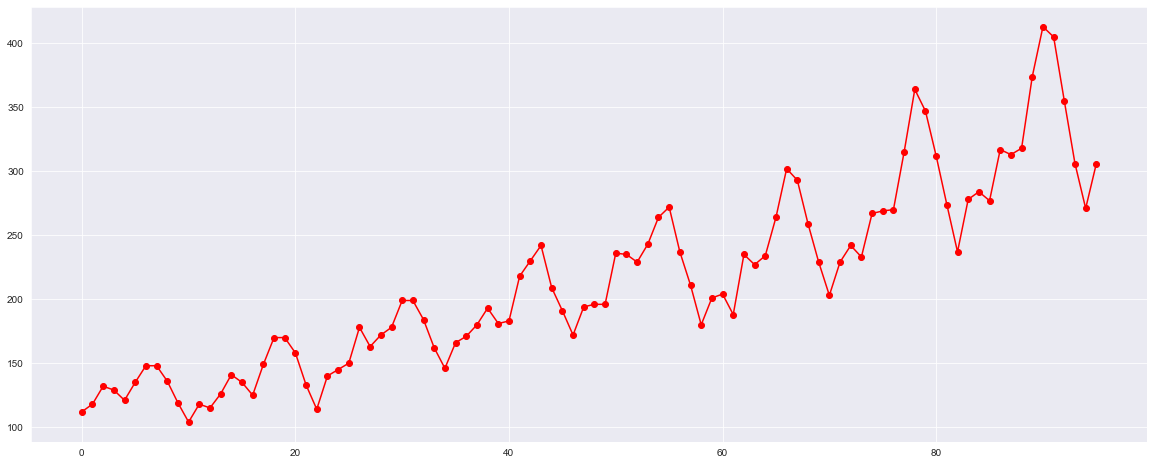

In [18]:
ap_data_mdf['passengers'].plot(figsize=(20, 8),color='red',marker='o')
plt.show()

#### Box plot

<AxesSubplot:xlabel='year', ylabel='passengers'>

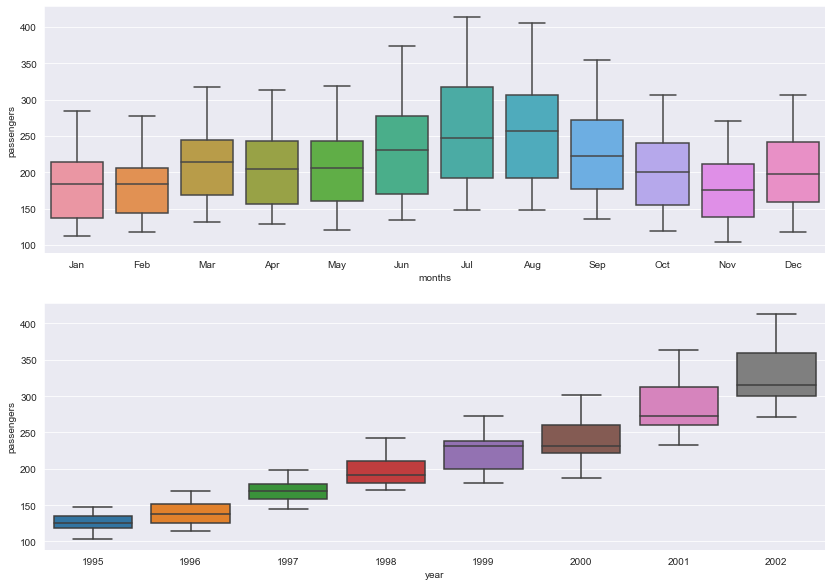

In [19]:
plt.figure(figsize=(14,10))
plt.subplot(211)
sb.boxplot(x='months', y='passengers', data=ap_data_mdf)
plt.subplot(212)
sb.boxplot(x='year', y='passengers', data=ap_data_mdf)

#### Yearly Passengers plot

<AxesSubplot:xlabel='year', ylabel='passengers'>

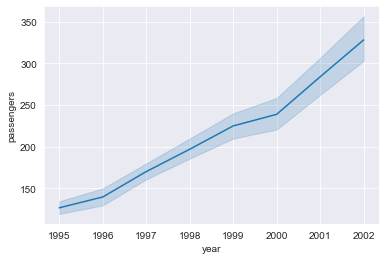

In [20]:
sb.lineplot(x='year',y='passengers',data=ap_data_mdf)

#### Monthly Passengers plot

<AxesSubplot:xlabel='months', ylabel='passengers'>

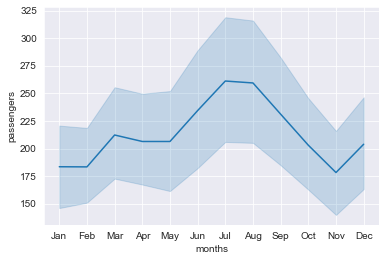

In [21]:
sb.lineplot(x='months',y='passengers',data=ap_data_mdf)

#### Histogram

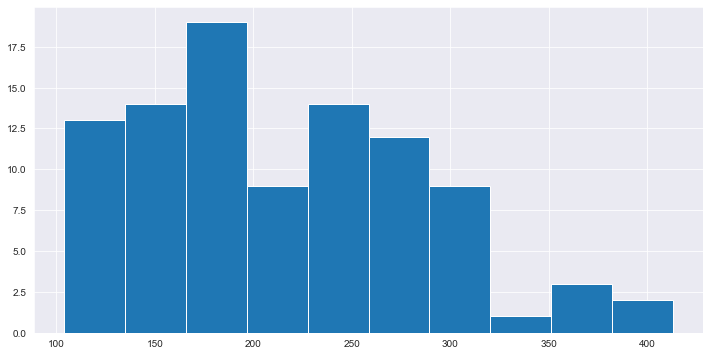

In [22]:
ap_data_mdf.passengers.hist(figsize=(12,6))
plt.show()

#### Density plot

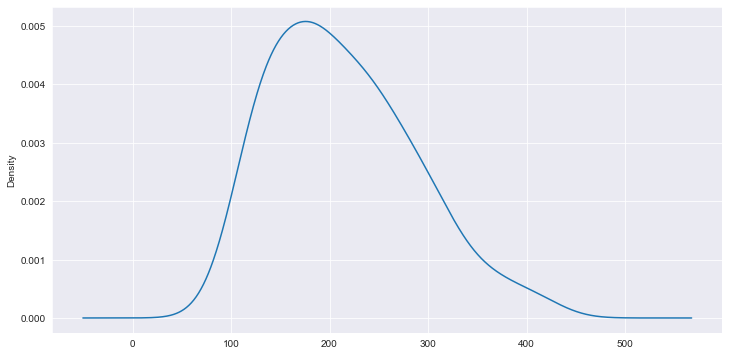

In [23]:
ap_data_mdf.passengers.plot(kind='kde', figsize=(12,6))
plt.show()

#### Lag plot

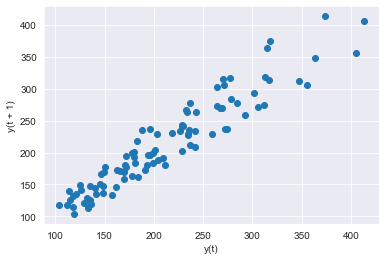

In [24]:
lag_plot(ap_data_mdf.passengers)
plt.show()

#### Plotting Moving Average

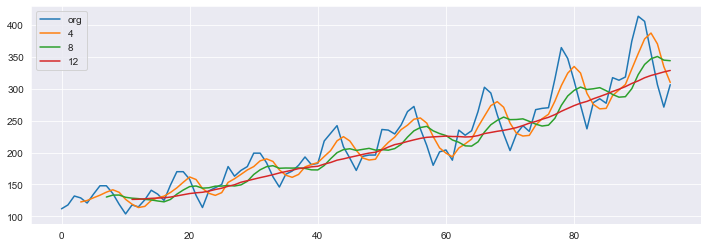

In [25]:
plt.figure(figsize=(12,4))
ap_data_mdf.passengers.plot(label="org")
for i in range(4,13,4):
    ap_data_mdf["passengers"].rolling(i).mean().plot(label=str(i))
plt.legend(loc='best') 

#### Time series decomposition plot 

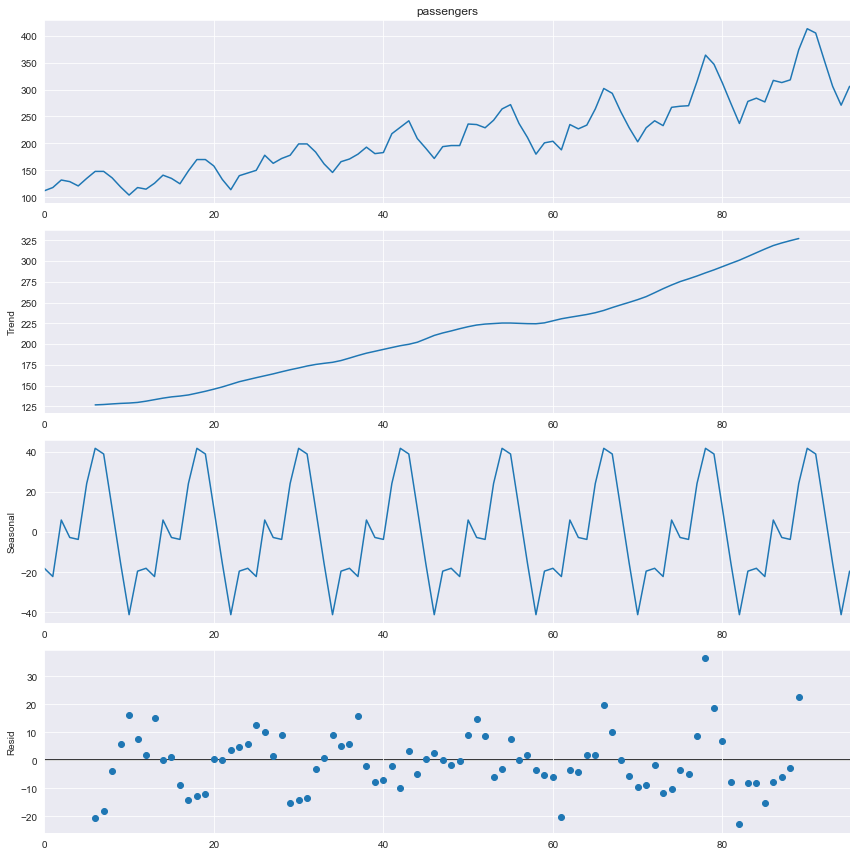

In [26]:
decompose_ts_add = seasonal_decompose(ap_data_mdf.passengers,period=12)
with plt.rc_context():
    plt.rc("figure", figsize=(12,12))
    decompose_ts_add.plot()
    plt.show()

### ACF plots and PACF plots

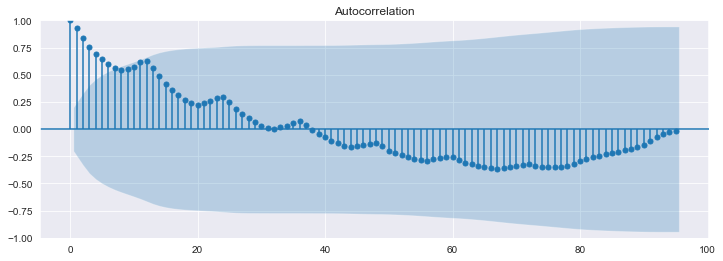

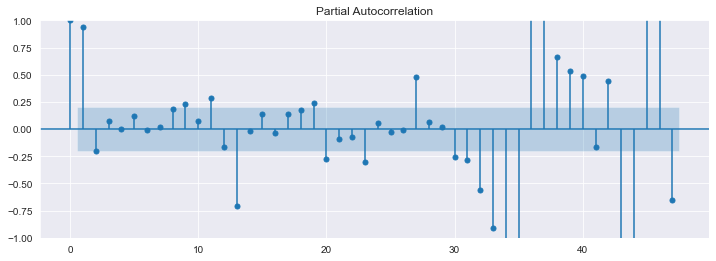

In [27]:
with plt.rc_context():
    plt.rc("figure", figsize=(12,4))
    tsa_plots.plot_acf(ap_data_mdf.passengers,lags=95)
    tsa_plots.plot_pacf(ap_data_mdf.passengers,lags=47)
    plt.show()

### Step-5 : Split the data into training and testing data

In [28]:
x_train = ap_data_mdf.head(76)
x_test  = ap_data_mdf.tail(20)
print(x_train.shape)
print(x_test.shape)

(76, 19)
(20, 19)


### Step-6 : Build different models for Forecasting

#### Evaluation Metric MAPE

In [29]:
def MAPE(pred,org):
    temp = np.abs((pred-org)/org)*100
    return np.mean(temp)

### Step-6.1 : Data-Driven Techniques

#### Simple Exponential Method

In [30]:
model_ses = SimpleExpSmoothing(x_train["passengers"]).fit(smoothing_level=0.2)
pred_ses = model_ses.predict(start = x_test.index[0],end = x_test.index[-1])
mape_ses = np.round(MAPE(pred_ses,x_test.passengers),2)  
rmse_ses = np.round(np.sqrt(mean_squared_error(pred_ses,x_test.passengers)),2)
print("Mean Absolute Percentage Error : ",mape_ses)
print("Root Mean Square Error : ",rmse_ses)

Mean Absolute Percentage Error :  20.43
Root Mean Square Error :  82.12


#### Holt's Method (Double Exponential Method)

In [31]:
model_h = Holt(x_train["passengers"]).fit(smoothing_level=0.8, smoothing_slope=0.2)
pred_h = model_h.predict(start = x_test.index[0],end = x_test.index[-1])
mape_h = np.round(MAPE(pred_h,x_test.passengers),2)
rmse_h = np.round(np.sqrt(mean_squared_error(pred_h,x_test.passengers)),2)
print("Mean Absolute Percentage Error : ",mape_h)
print("Root Mean Square Error : ",rmse_h)

Mean Absolute Percentage Error :  12.96
Root Mean Square Error :  47.99


#### Holt-Winter's Exponential Smoothing with Additive Seasonality and Trend (Triple Exponential Method)

In [32]:
model_hw_as_at = ExponentialSmoothing(x_train["passengers"],seasonal="add",trend="add",seasonal_periods=12).fit(optimized=True)
pred_hw_as_at = model_hw_as_at.predict(start = x_test.index[0],end = x_test.index[-1])
mape_hw_as_at = np.round(MAPE(pred_hw_as_at,x_test.passengers),2)
rmse_hw_as_at = np.round(np.sqrt(mean_squared_error(pred_hw_as_at,x_test.passengers)),2)
print("Mean Absolute Percentage Error : ",mape_hw_as_at)
print("Root Mean Square Error : ",rmse_hw_as_at)

Mean Absolute Percentage Error :  8.72
Root Mean Square Error :  37.73


#### Holt-Winter's Exponential Smoothing with Multiplicative Seasonality and Additive Trend (Triple Exponential Method)

In [33]:
model_hw_ms_at = ExponentialSmoothing(x_train["passengers"],seasonal="mul",trend="add",seasonal_periods=12).fit(optimized=True)
pred_hw_ms_at = model_hw_ms_at.predict(start = x_test.index[0],end = x_test.index[-1])
mape_hw_ms_at = np.round(MAPE(pred_hw_ms_at,x_test.passengers),2)
rmse_hw_ms_at = np.round(np.sqrt(mean_squared_error(pred_hw_ms_at,x_test.passengers)),2)
print("Mean Absolute Percentage Error : ",mape_hw_ms_at)
print("Root Mean Square Error : ",rmse_hw_ms_at)

Mean Absolute Percentage Error :  9.38
Root Mean Square Error :  33.88


#### Holt-Winter's Exponential Smoothing with Additive Seasonality and Multiplicative Trend (Triple Exponential Method)

In [34]:
model_hw_as_mt = ExponentialSmoothing(x_train["passengers"],seasonal="add",trend="mul",seasonal_periods=12).fit(optimized=True)
pred_hw_as_mt = model_hw_as_mt.predict(start = x_test.index[0],end = x_test.index[-1])
mape_hw_as_mt = np.round(MAPE(pred_hw_as_mt,x_test.passengers),2)
rmse_hw_as_mt =np.round(np.sqrt(mean_squared_error(pred_hw_as_mt,x_test.passengers)),2)
print("Mean Absolute Percentage Error : ",mape_hw_as_mt)
print("Root Mean Square Error : ",rmse_hw_as_mt)

Mean Absolute Percentage Error :  6.54
Root Mean Square Error :  30.78


#### Holt-Winter's Exponential Smoothing with Multiplicative Seasonality and Multiplicative Trend (Triple Exponential Method)

In [35]:
model_hw_ms_mt = ExponentialSmoothing(x_train["passengers"],seasonal="mul",trend="mul",seasonal_periods=12).fit(optimized=True)
pred_hw_ms_mt = model_hw_ms_mt.predict(start = x_test.index[0],end = x_test.index[-1])
mape_hw_ms_mt = np.round(MAPE(pred_hw_ms_mt,x_test.passengers),2)
rmse_hw_ms_mt = np.round(np.sqrt(mean_squared_error(pred_hw_ms_mt,x_test.passengers)),2)
print("Mean Absolute Percentage Error : ",mape_hw_ms_mt)
print("Root Mean Square Error : ",rmse_hw_ms_mt)

Mean Absolute Percentage Error :  6.26
Root Mean Square Error :  23.46


In [36]:
# grid search ARIMA parameters for a time series

# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
# prepare training dataset
    X = X.astype('float32')
    train_size = int(len(X) * 0.70)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
# make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
# calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

In [37]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float('inf'), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(train, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))  

In [38]:
train = pd.read_excel('Airlines+Data.xlsx', index_col=0, parse_dates=True, squeeze=True)

In [66]:
train.values

array([112, 118, 132, 129, 121, 135, 148, 148, 136, 119, 104, 118, 115,
       126, 141, 135, 125, 149, 170, 170, 158, 133, 114, 140, 145, 150,
       178, 163, 172, 178, 199, 199, 184, 162, 146, 166, 171, 180, 193,
       181, 183, 218, 230, 242, 209, 191, 172, 194, 196, 196, 236, 235,
       229, 243, 264, 272, 237, 211, 180, 201, 204, 188, 235, 227, 234,
       264, 302, 293, 259, 229, 203, 229, 242, 233, 267, 269, 270, 315,
       364, 347, 312, 274, 237, 278, 284, 277, 317, 313, 318, 374, 413,
       405, 355, 306, 271, 306], dtype=int64)

In [40]:
# evaluate parameters
train = pd.read_excel('Airlines+Data.xlsx', index_col=0, parse_dates=True, squeeze=True)
p_values = range(0, 3)
d_values = range(0, 3)
q_values = range(0, 3)
evaluate_models(train.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=111.095
ARIMA(0, 0, 1) RMSE=59.116
ARIMA(0, 0, 2) RMSE=44.620
ARIMA(0, 1, 0) RMSE=31.695
ARIMA(0, 1, 1) RMSE=29.499
ARIMA(0, 1, 2) RMSE=29.313
ARIMA(0, 2, 0) RMSE=36.861
ARIMA(0, 2, 1) RMSE=31.972
ARIMA(0, 2, 2) RMSE=29.718
ARIMA(1, 0, 0) RMSE=31.920
ARIMA(1, 0, 1) RMSE=29.364
ARIMA(1, 0, 2) RMSE=29.417
ARIMA(1, 1, 0) RMSE=30.535
ARIMA(1, 1, 1) RMSE=29.010
ARIMA(1, 1, 2) RMSE=27.580
ARIMA(1, 2, 0) RMSE=37.615
ARIMA(1, 2, 1) RMSE=30.794
ARIMA(1, 2, 2) RMSE=29.263
ARIMA(2, 0, 0) RMSE=30.492
ARIMA(2, 0, 1) RMSE=29.298
ARIMA(2, 0, 2) RMSE=29.116
ARIMA(2, 1, 0) RMSE=29.366
ARIMA(2, 1, 1) RMSE=27.423
ARIMA(2, 1, 2) RMSE=27.162
ARIMA(2, 2, 0) RMSE=36.001
ARIMA(2, 2, 1) RMSE=29.673
ARIMA(2, 2, 2) RMSE=29.543
Best ARIMA(2, 1, 2) RMSE=27.162


In [41]:
train

Month
1995-01-01    112
1995-02-01    118
1995-03-01    132
1995-04-01    129
1995-05-01    121
             ... 
2002-08-01    405
2002-09-01    355
2002-10-01    306
2002-11-01    271
2002-12-01    306
Name: Passengers, Length: 96, dtype: int64

In [42]:
train.values

array([112, 118, 132, 129, 121, 135, 148, 148, 136, 119, 104, 118, 115,
       126, 141, 135, 125, 149, 170, 170, 158, 133, 114, 140, 145, 150,
       178, 163, 172, 178, 199, 199, 184, 162, 146, 166, 171, 180, 193,
       181, 183, 218, 230, 242, 209, 191, 172, 194, 196, 196, 236, 235,
       229, 243, 264, 272, 237, 211, 180, 201, 204, 188, 235, 227, 234,
       264, 302, 293, 259, 229, 203, 229, 242, 233, 267, 269, 270, 315,
       364, 347, 312, 274, 237, 278, 284, 277, 317, 313, 318, 374, 413,
       405, 355, 306, 271, 306], dtype=int64)

In [43]:
# prepare data
X = x_train.copy()
X = X.iloc[:,:2]
X = X.set_index('date')
X = X.astype('float32') 

In [67]:
X

,passengers
date,
1995-01-01,112.0
1995-02-01,118.0
1995-03-01,132.0
1995-04-01,129.0
1995-05-01,121.0
...,...
2000-12-01,229.0
2001-01-01,242.0
2001-02-01,233.0


In [44]:
# fit model
model_arima = ARIMA(X, order=(2,1,2)).fit()
pred_arima = model_arima.predict(start = x_test.index[0],end = x_test.index[-1])
mape_arima = np.round(MAPE(pred_arima.values,x_test.passengers.values),2)
rmse_arima = np.round(np.sqrt(mean_squared_error(pred_arima,x_test.passengers)),2)
print("Mean Absolute Percentage Error : ",mape_arima)
print("Root Mean Square Error : ",rmse_arima)

Mean Absolute Percentage Error :  14.72
Root Mean Square Error :  60.03


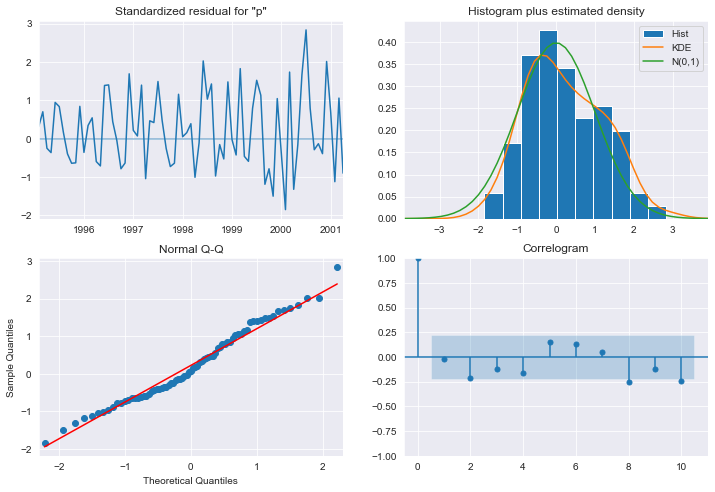

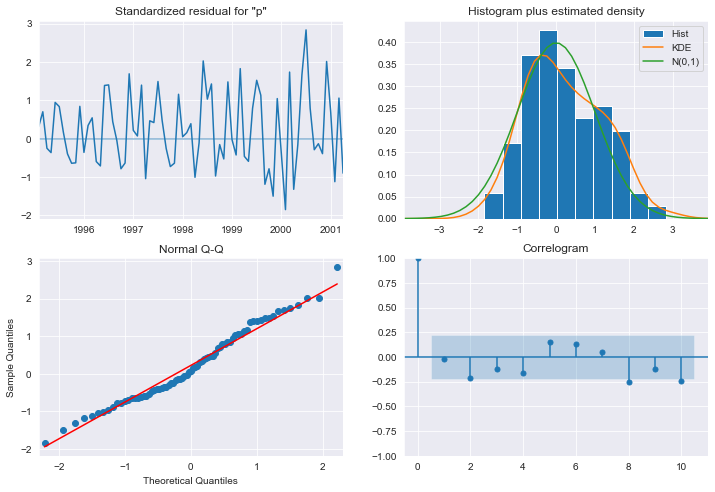

In [45]:
model_arima.plot_diagnostics(figsize=(12,8)) 

### Step-6.1.1 : Comparing the results

In [46]:
pd.set_option('max_colwidth',100)

In [47]:
model_list                = ["SES Method","Holt's Method",
                             "H-W's Exp. Smooothing with Add. Seasonality and Trend",
                             "H-W's Exp. Smoothing with Mul. Seasonality and Add. Trend",
                             "H-W's Exp. Smoothing with Add. Seasonality and Mul. Trend",
                             "H-W's Exp. Smoothing with Mul. Seasonality and Mul. Trend",
                             "ARIMA"
                            ]
rmse_val_list             = [rmse_ses,rmse_h,rmse_hw_as_at,rmse_hw_ms_at,rmse_hw_as_mt,rmse_hw_ms_mt
                             ,rmse_arima]

table_rmse                = pd.DataFrame(columns=['Model','RMSE_Values'])
table_rmse['Model']       = model_list
table_rmse['RMSE_Values'] = rmse_val_list
table_rmse.sort_values('RMSE_Values')

,Model,RMSE_Values
5,H-W's Exp. Smoothing with Mul. Seasonality and Mul. Trend,23.46
4,H-W's Exp. Smoothing with Add. Seasonality and Mul. Trend,30.78
3,H-W's Exp. Smoothing with Mul. Seasonality and Add. Trend,33.88
2,H-W's Exp. Smooothing with Add. Seasonality and Trend,37.73
1,Holt's Method,47.99
6,ARIMA,60.03
0,SES Method,82.12


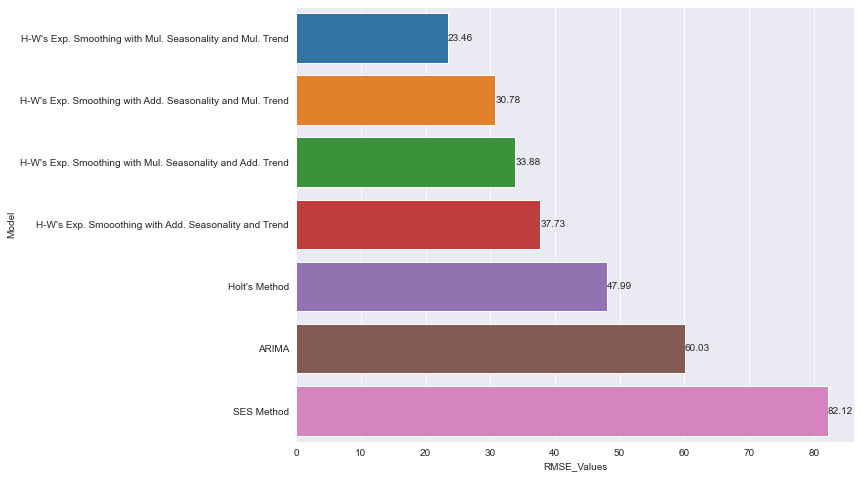

In [48]:
plt.figure(figsize=(10,8))
ax = sb.barplot(x='RMSE_Values',y='Model',data=table_rmse,order=table_rmse.sort_values('RMSE_Values').Model)
for i in ax.containers:
    ax.bar_label(i)

### Step-6.2 : Model Driven Techniques

#### Linear Model

In [49]:
model_lin     = smf.ols('passengers~t',data=x_train).fit()
predicted_lin = pd.Series(model_lin.predict(pd.DataFrame(x_test['t'])))
rmse_lin      = np.sqrt(np.mean(np.array(x_test['passengers'])-np.array(predicted_lin))**2)
rmse_lin      = round(rmse_lin,2)
print("Root Mean Square Error : ",rmse_lin)

Root Mean Square Error :  36.02


#### Exponential Model

In [50]:
model_exp = smf.ols('log_passengers~t',data=x_train).fit()
pred_exp  = pd.Series(model_exp.predict(pd.DataFrame(x_test['t'])))
rmse_exp  = np.sqrt(np.mean((np.array(x_test['log_passengers'])-np.array(np.exp(pred_exp)))**2))
rmse_exp  = round(rmse_exp,2)
print("Root Mean Square Error : ",rmse_exp)

Root Mean Square Error :  298.66


#### Quadratic 

In [51]:
model_quad = smf.ols('passengers~t+t_square',data=x_train).fit()
pred_quad = pd.Series(model_quad.predict(x_test[["t","t_square"]]))
rmse_quad = np.sqrt(np.mean((np.array(x_test['passengers'])-np.array(pred_quad))**2))
rmse_quad = round(rmse_quad,2)
print("Root Mean Square Error : ",rmse_quad)

Root Mean Square Error :  58.49


#### Additive seasonality 

In [52]:
model_add_sea = smf.ols('passengers~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data=x_train).fit()
pred_add_sea = pd.Series(model_add_sea.predict(x_test[['Jan','Feb','Mar','Apr','May','Jun','Jul',
                                               'Aug','Sep','Oct','Nov','Dec']]))
rmse_add_sea = np.sqrt(np.mean((np.array(x_test['passengers'])-np.array(pred_add_sea))**2))
rmse_add_sea = round(rmse_add_sea,2)
print("Root Mean Square Error : ",rmse_add_sea)

Root Mean Square Error :  132.25


#### Additive Seasonality Quadratic 

In [53]:
model_add_sea_quad = smf.ols('passengers~t+t_square+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data=x_train).fit()
pred_add_sea_quad = pd.Series(model_add_sea_quad.predict(x_test[['Jan','Feb','Mar','Apr','May','Jun','Jul',
                                               'Aug','Sep','Oct','Nov','Dec','t','t_square']]))
rmse_add_sea_quad = np.sqrt(np.mean((np.array(x_test['passengers'])-np.array(pred_add_sea_quad))**2))
rmse_add_sea_quad = round(rmse_add_sea_quad,2)
print("Root Mean Square Error : ",rmse_add_sea_quad)

Root Mean Square Error :  39.76


#### Multiplicative Seasonality

In [54]:
model_mul_sea = smf.ols('log_passengers~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',
                  data = x_train).fit()
pred_mul_sea = pd.Series(model_mul_sea.predict(x_test))
rmse_mul_sea = np.sqrt(np.mean((np.array(x_test['passengers'])-np.array(np.exp(pred_mul_sea)))**2))
rmse_mul_sea = round(rmse_mul_sea,2)
print("Root Mean Square Error : ",rmse_mul_sea)

Root Mean Square Error :  137.61


#### Multiplicative Additive Seasonality 

In [55]:
model_mul_add_sea = smf.ols('log_passengers~t+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data = x_train).fit()
pred_mul_add_sea = pd.Series(model_mul_add_sea.predict(x_test))
rmse_mul_add_sea = np.sqrt(np.mean((np.array(x_test['passengers'])-np.array(np.exp(pred_mul_add_sea)))**2))
rmse_mul_add_sea = round(rmse_mul_add_sea,2)
print("Root Mean Square Error : ",rmse_mul_add_sea)

Root Mean Square Error :  11.78


### Step-6.2.1 : Comparing the results

In [56]:
model_list                = ["Linear","Exponential","Quadratic","Additive Seasonality","Additive Seasonality Quadratic","Multiplicative Seasonality",
                                 "Multiplicative Additive Seasonality"]
rmse_val_list             = [rmse_lin,rmse_exp,rmse_quad,rmse_add_sea,rmse_add_sea_quad,rmse_mul_sea,
                                 rmse_mul_add_sea]

table_rmse                = pd.DataFrame(columns=['Model','RMSE_Values'])
table_rmse['Model']       = model_list
table_rmse['RMSE_Values'] = rmse_val_list

table_rmse.sort_values(by=['RMSE_Values'])

,Model,RMSE_Values
6,Multiplicative Additive Seasonality,11.78
0,Linear,36.02
4,Additive Seasonality Quadratic,39.76
2,Quadratic,58.49
3,Additive Seasonality,132.25
5,Multiplicative Seasonality,137.61
1,Exponential,298.66


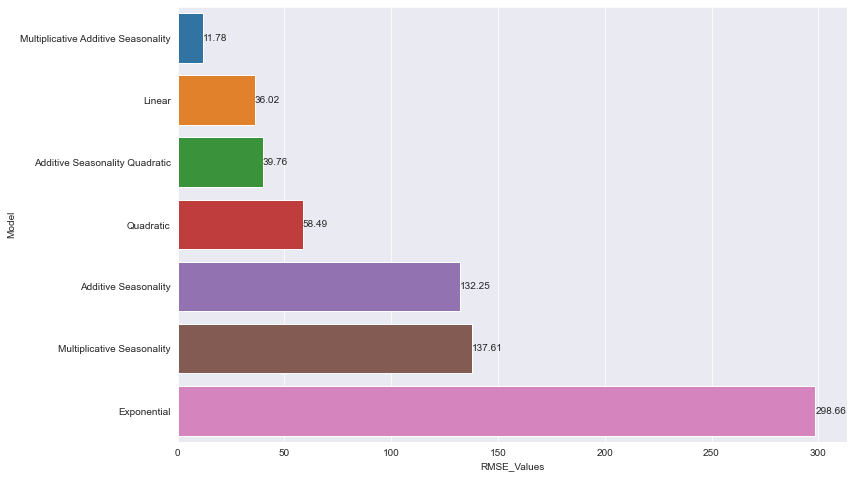

In [57]:
plt.figure(figsize=(12,8))
ax = sb.barplot(x='RMSE_Values',y='Model',data=table_rmse,order=table_rmse.sort_values('RMSE_Values').Model)
for i in ax.containers:
    ax.bar_label(i)

### Step-7 : Predict for new time period

#### Out of all the models, Multiplicative Additive Seasonality gave the lowest error. Hence use this model for forecasting.

In [58]:
new_data = ap_data_mdf.tail(12)
new_data

,date,passengers,t,t_square,log_passengers,months,year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
84,2002-01-01,284,85,7225,5.648974,Jan,2002,1,0,0,0,0,0,0,0,0,0,0,0
85,2002-02-01,277,86,7396,5.624018,Feb,2002,0,1,0,0,0,0,0,0,0,0,0,0
86,2002-03-01,317,87,7569,5.758902,Mar,2002,0,0,1,0,0,0,0,0,0,0,0,0
87,2002-04-01,313,88,7744,5.746203,Apr,2002,0,0,0,1,0,0,0,0,0,0,0,0
88,2002-05-01,318,89,7921,5.762051,May,2002,0,0,0,0,1,0,0,0,0,0,0,0
89,2002-06-01,374,90,8100,5.924256,Jun,2002,0,0,0,0,0,1,0,0,0,0,0,0
90,2002-07-01,413,91,8281,6.023448,Jul,2002,0,0,0,0,0,0,1,0,0,0,0,0
91,2002-08-01,405,92,8464,6.003887,Aug,2002,0,0,0,0,0,0,0,1,0,0,0,0
92,2002-09-01,355,93,8649,5.872118,Sep,2002,0,0,0,0,0,0,0,0,1,0,0,0
93,2002-10-01,306,94,8836,5.723585,Oct,2002,0,0,0,0,0,0,0,0,0,1,0,0


In [59]:
new_data.drop(columns=['passengers','log_passengers','year','months'], axis=1, inplace=True)

In [60]:
new_data

,date,t,t_square,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
84,2002-01-01,85,7225,1,0,0,0,0,0,0,0,0,0,0,0
85,2002-02-01,86,7396,0,1,0,0,0,0,0,0,0,0,0,0
86,2002-03-01,87,7569,0,0,1,0,0,0,0,0,0,0,0,0
87,2002-04-01,88,7744,0,0,0,1,0,0,0,0,0,0,0,0
88,2002-05-01,89,7921,0,0,0,0,1,0,0,0,0,0,0,0
89,2002-06-01,90,8100,0,0,0,0,0,1,0,0,0,0,0,0
90,2002-07-01,91,8281,0,0,0,0,0,0,1,0,0,0,0,0
91,2002-08-01,92,8464,0,0,0,0,0,0,0,1,0,0,0,0
92,2002-09-01,93,8649,0,0,0,0,0,0,0,0,1,0,0,0
93,2002-10-01,94,8836,0,0,0,0,0,0,0,0,0,1,0,0


In [61]:
ap_data_mdf1 = ap_data_mdf.head(84)
print(ap_data_mdf1.shape)
ap_data_mdf1

(84, 19)


,date,passengers,t,t_square,log_passengers,months,year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,1995-01-01,112,1,1,4.718499,Jan,1995,1,0,0,0,0,0,0,0,0,0,0,0
1,1995-02-01,118,2,4,4.770685,Feb,1995,0,1,0,0,0,0,0,0,0,0,0,0
2,1995-03-01,132,3,9,4.882802,Mar,1995,0,0,1,0,0,0,0,0,0,0,0,0
3,1995-04-01,129,4,16,4.859812,Apr,1995,0,0,0,1,0,0,0,0,0,0,0,0
4,1995-05-01,121,5,25,4.795791,May,1995,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,2001-08-01,347,80,6400,5.849325,Aug,2001,0,0,0,0,0,0,0,1,0,0,0,0
80,2001-09-01,312,81,6561,5.743003,Sep,2001,0,0,0,0,0,0,0,0,1,0,0,0
81,2001-10-01,274,82,6724,5.613128,Oct,2001,0,0,0,0,0,0,0,0,0,1,0,0
82,2001-11-01,237,83,6889,5.468060,Nov,2001,0,0,0,0,0,0,0,0,0,0,1,0


In [62]:
#picked the model with the lowest RMSE value
#training the model on the entire dataset
final_model = smf.ols('log_passengers~t+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data = ap_data_mdf1).fit()

In [63]:
predicted_new = final_model.predict(new_data)
predicted_new

84    5.632141
85    5.647734
86    5.792098
87    5.756366
88    5.746648
89    5.865009
90    5.972273
91    5.972648
92    5.865485
93    5.738005
94    5.606271
95    5.744972
dtype: float64

In [64]:
new_data['forecasted_passengers'] = predicted_new
new_data

,date,t,t_square,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,forecasted_passengers
84,2002-01-01,85,7225,1,0,0,0,0,0,0,0,0,0,0,0,5.632141
85,2002-02-01,86,7396,0,1,0,0,0,0,0,0,0,0,0,0,5.647734
86,2002-03-01,87,7569,0,0,1,0,0,0,0,0,0,0,0,0,5.792098
87,2002-04-01,88,7744,0,0,0,1,0,0,0,0,0,0,0,0,5.756366
88,2002-05-01,89,7921,0,0,0,0,1,0,0,0,0,0,0,0,5.746648
89,2002-06-01,90,8100,0,0,0,0,0,1,0,0,0,0,0,0,5.865009
90,2002-07-01,91,8281,0,0,0,0,0,0,1,0,0,0,0,0,5.972273
91,2002-08-01,92,8464,0,0,0,0,0,0,0,1,0,0,0,0,5.972648
92,2002-09-01,93,8649,0,0,0,0,0,0,0,0,1,0,0,0,5.865485
93,2002-10-01,94,8836,0,0,0,0,0,0,0,0,0,1,0,0,5.738005


<AxesSubplot:>

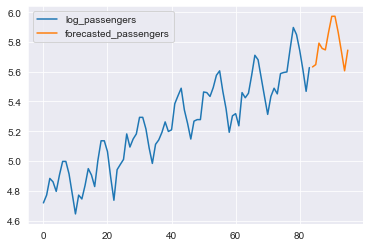

In [65]:
new_var = pd.concat([ap_data_mdf1,new_data])
new_var[['log_passengers','forecasted_passengers']].reset_index(drop=True).plot()